In [1]:
from typing import List, Tuple, Iterable, Dict
from collections import defaultdict

from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import wandb
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from rdkit import Chem
from rdkit.Chem import BRICS
from rdkit.Chem import Draw
import plotly.express as px
import plotly.graph_objects as go

import XAIChem

## Load data

In [2]:
train_data = XAIChem.Dataset(root="../data", name="ESOL", tag="train")
val_data = XAIChem.Dataset(root="../data", name="ESOL", tag="val")
test_data = XAIChem.Dataset(root="../data", name="ESOL", tag="test")

In [3]:
train_loader = DataLoader(train_data, batch_size=256)
val_loader = DataLoader(val_data, batch_size=256)
test_loader = DataLoader(test_data, batch_size=256)

## Model training and evaluation setup

In [4]:
def train(loader, model, criterion, optimzer):
    """
    Perform one epoch of the training step
    """
    model.train()

    # Iterate through the batches
    for i, data in enumerate(loader):
        data.to(device)
        
        out = model(data.x, data.edge_index, data.edge_type, data.batch)
        loss = criterion(out, data.y.view(-1, 1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [5]:
def evaluate(loader, model, criterion):
    model.eval()

    with torch.no_grad():
        # Log average loss of batches
        losses = torch.zeros(len(loader))
    
        # Save all predictions and labels to compute the 
        # coefficient of determination (i.e. R^2) of the 
        # whole data set
        predictions = torch.zeros(len(loader.dataset))
        labels = torch.zeros(len(loader.dataset))
    
        index = 0
        for i, data in enumerate(loader):
            data.to(device)
            
            pred = model(data.x, data.edge_index, data.edge_type, data.batch)
            losses[i] = criterion(pred, data.y.view(-1, 1))
    
            new_index = index + data.batch_size
            predictions[index:new_index] = pred.view(1, -1)
            labels[index:new_index] = data.y
            index = new_index
    
        r2 = r2_score(labels, predictions)

    return r2, torch.mean(losses)

## Train models

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# wandb will be used to log the training progress
wandb.login()

for model_id in range(10):
    
    config = {
        "architecture": "RGCN by Wu et al.",
        "dataset": "ESOL from Wu et al.",
        "epochs": 500,
        "random_seed": 2022 + model_id * 10,
        "learning_rate": 0.003,
        "rgcn_dropout_rate": 0.5,
        "mlp_dropout_rate": 0.1
    }

    wandb.init(project="ESOL_reproduction", name=f"model_{model_id}_c", config=config)
    XAIChem.set_seed(config["random_seed"])

    model = XAIChem.RGCN(num_node_features=XAIChem.getNumAtomFeatures()).to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

    for epoch in range(config["epochs"]):
    
        train(train_loader, model, criterion, optimizer)
    
        train_r2, train_loss = evaluate(train_loader, model, criterion)
        val_r2, val_loss = evaluate(val_loader, model, criterion)
        test_r2, test_loss = evaluate(test_loader, model, criterion)
    
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_r2": train_r2,
            "val_loss": val_loss,
            "val_r2": val_r2,
            "test_loss": test_loss,
            "test_r2": test_r2,
        })
    
    torch.save(
        model.state_dict(),
        f"../data/trained_models/ESOL/ESOL_rgcn_model_{model_id}_c.pt"
    )
    wandb.finish()

wandb: Currently logged in as: xwieme (mlchem). Use `wandb login --relogin` to force relogin


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_r2,▁███████████████████████████████████████
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▇██████████████████████████████████████
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_r2,▁▇██████████████████████████████████████
epoch,499
test_loss,0.3785
test_r2,0.91211
train_loss,0.05141


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_r2,▁▇██████████████████████████████████████
train_loss,█▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▆▇▇█▇██████████████████████████████████
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_r2,▁▆▇█████████████████████████████████████
epoch,499
test_loss,0.45366
test_r2,0.89466
train_loss,0.07775


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_r2,▁▆▇█████████████████████████████████████
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▆▇▇████████████████████████████████████
val_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_r2,▁▅▆▇████████████████████████████████████
epoch,499
test_loss,0.40663
test_r2,0.90558
train_loss,0.0553


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_r2,▁▇██▇███████████████████████████████████
train_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▇▇▇▇███████████████████████████████████
val_loss,█▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_r2,▁▇▇█▇███████████████████████████████████
epoch,499
test_loss,0.38754
test_r2,0.91001
train_loss,0.0468


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_r2,▁▆▇█████████████████████████████████████
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▆▇▇████████████████████████████████████
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_r2,▁▆▇█████████████████████████████████████
epoch,499
test_loss,0.40536
test_r2,0.90587
train_loss,0.05369


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_r2,▁▆▇█████████████████████████████████████
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▆▇▇████████████████████████████████████
val_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_r2,▁▅▆▇████████████████████████████████████
epoch,499
test_loss,0.36864
test_r2,0.9144
train_loss,0.0444


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_r2,▁▇▇█████████████████████████████████████
train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▆▇█████████████████████████████████████
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_r2,▁▆▇█████████████████████████████████████
epoch,499
test_loss,0.4328
test_r2,0.8995
train_loss,0.04727


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_r2,▁▇▇▇▇███████████████████████████████████
train_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▆▇▇▇▇██████████████████████████████████
val_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_r2,▁▆▇▇▇▇██████████████████████████████████
epoch,499
test_loss,0.40823
test_r2,0.90521
train_loss,0.04438


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_r2,▁▇▇█████████████████████████████████████
train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▇▇▇█▇██████████████████████████████████
val_loss,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_r2,▁▇▇▇█▇██████████████████████████████████
epoch,499
test_loss,0.42568
test_r2,0.90115
train_loss,0.07132


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_r2,▁▇██████████████████████████████████████
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▆▇▇████████████████████████████████████
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_r2,▁▆▇▇████████████████████████████████████
epoch,499
test_loss,0.39585
test_r2,0.90808
train_loss,0.06903


## Substructure mask explanation

In [17]:
models = []

for model_id in range(10):
    model = XAIChem.RGCN(num_node_features=XAIChem.getNumAtomFeatures())
    model.load_state_dict(
        torch.load(
            f"../data/trained_models/ESOL/ESOL_rgcn_model_{model_id}_c.pt",
            map_location=torch.device('cpu')
        )
    )
    model.eval()
    models.append(model)

In [18]:
def predict(graph, mask=None):

    with torch.no_grad():
        predictions = torch.zeros(10)
        for i, model in enumerate(models):
            predictions[i] = model(
                graph.x, 
                graph.edge_index, 
                graph.edge_type, 
                torch.zeros(1, dtype=torch.long),
                mask
            )

    return torch.mean(predictions)


def predictBatch(data, masks=None):

    with torch.no_grad():
        predictions = torch.zeros(data.batch_size, len(models))
        for i, model in enumerate(models):
            
            predictions[:, i] = model(
                data.x, 
                data.edge_index, 
                data.edge_type, 
                data.batch,
                masks
            ).view(-1)

    return torch.mean(predictions, dim=1)

In [19]:
def createMask(molecule: Chem.rdchem.Mol, substructure: Iterable[int]) -> torch.Tensor:
    
    mask = torch.zeros(molecule.GetNumAtoms(), dtype=int)
    for i, atom in enumerate(molecule.GetAtoms()):
        mask[i] = atom.GetIdx() not in substructure
    
    return mask.view(-1, 1)

In [20]:
functional_groups = [
    "[C;D4]([C;D1])([C;D1])-[C;D1]", "[S;D1]", "[C;D4](F)(F)F", "[S;D2]-[C;D1;H3]", 
    "[C;D2]#[C;D1;H1]", "[#6][F,Cl,Br,I]", "[O;D2]-[C;D2;H2]-[C;D1;H3]",
    "[N]#[C]", "[N;D3](=[O;D1])[O;D1]", "[O;D2;H1]-[C;D1;H3]", 
    "C(=[O;D1])[O;D2]-[C;D1;H3]", "[O;D1;H1]", "C(=[O;D1])-[N;D1]",
    "[N;D1;H2]", "C(=[O;D1])-[C;D1;H3]", "[S;D4](=[O;D1])(=[O;D1])-[N;D1;H2]"
]

In [21]:
def functionGroupAttributionScores(
    smiles: str, 
    functional_groups: List[str],
    key: str = "atom_ids"
) -> Dict[str,list]:
    """
    Compute the attribution scores for all present functional groups.

    :param smiles: smiles represenation of the molecule
    :param functional_groups: list of functional groups to search for in the molecule
    :param key: determines the structure of the output dictionairy. If key is 
        'atom_ids', than a dictionairy with atom ids as keys and the associated 
        attribution score will be returned e.g.
            {(0,): -0.3, (5, 4, 3): 0.3}.
        If key is 'functional_groups', then a dictionairy with functional group 
        smarts as keys and a list of attribution scores will be returned 
        e.g. {"[N]#[C]": -0.035, "[O;D1;H1]": 0.7}

    """

    molecule = Chem.MolFromSmiles(smiles)

    # Get atom indices of present functional groups
    functional_groups_matches = dict()
    for functional_group in functional_groups:
        
        for match in molecule.GetSubstructMatches(
            Chem.MolFromSmarts(functional_group)
        ): 
            functional_groups_matches[match] = functional_group

    # Quit if no matches are found
    if len(functional_groups_matches) == 0:
        return
    
    masks = torch.cat([
        createMask(molecule, substructure)
        for substructure in functional_groups_matches.keys()
    ])

    # Create a batch with size of the number of functional groups that are present
    graph = XAIChem.createDataObjectFromSmiles(smiles, -1)
    graphs = DataLoader(
        [graph for _ in range(len(functional_groups_matches))], 
        batch_size=len(functional_groups_matches)
    )
    
    for data in graphs:
        pred = predictBatch(data)
        pred_masked = predictBatch(data, masks.view(-1, 1))

    if key == "atom_ids":
        # Create a dictionary with the atom indices of the functional groups as keys 
        # and the normalized attribution scores as values
        attribution_scores = dict(zip(
            functional_groups_matches.keys(),
            pred - pred_masked
        ))
    elif key == "functional_groups":
        # Create a dictuionary with the present functional groups as keys and a list 
        # of attribution scores as values
        attribution_scores = defaultdict(list)
        for i, functional_group in enumerate(functional_groups_matches.values()):
            attribution_scores[functional_group].append(
                pred[i] - pred_masked[i]
            )
    else:
        raise ValueError("Specified key does not exists. Please use either 'atom_ids' or 'functional_groups'")
        
    return attribution_scores

### ESOL data set

In [22]:
esol_df = pd.read_csv("../data/ESOL/ESOL.csv")
esol_df.head()

,smiles,ESOL,group
0,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...,-0.77,training
1,Cc1occc1C(=O)Nc1ccccc1,-3.30,training
2,CC(C)=CCCC(C)=CC=O,-2.06,training
3,c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21,-7.87,training
4,c1ccsc1,-1.33,training


In [23]:
tqdm.pandas()

In [24]:
esol_df["attributions"] = esol_df.smiles.progress_apply(
    functionGroupAttributionScores,
    functional_groups=functional_groups,
    key="functional_groups"
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1111/1111 [03:38<00:00,  5.08it/s]


In [25]:
esol_df.head()

,smiles,ESOL,group,attributions
0,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...,-0.77,training,"{'[N]#[C]': [tensor(0.0396)], '[O;D1;H1]': [te..."
1,Cc1occc1C(=O)Nc1ccccc1,-3.30,training,None
2,CC(C)=CCCC(C)=CC=O,-2.06,training,None
3,c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21,-7.87,training,None
4,c1ccsc1,-1.33,training,None


In [26]:
functional_group_attributions = defaultdict(list)

for attributions in esol_df["attributions"]:
    if attributions is not None:
        for functional_group, attribution in attributions.items():
            functional_group_attributions[functional_group].extend(attribution)

[N]#[C]                            : -0.354
[O;D1;H1]                          : 0.123
[#6][F,Cl,Br,I]                    : -0.669
[S;D1]                             : -0.358
[O;D2]-[C;D2;H2]-[C;D1;H3]         : -0.395
C(=[O;D1])-[C;D1;H3]               : 0.102
[C;D4](F)(F)F                      : -0.547
[N;D3](=[O;D1])[O;D1]              : -0.329
[N;D1;H2]                          : -0.025
C(=[O;D1])[O;D2]-[C;D1;H3]         : 0.019
[C;D4]([C;D1])([C;D1])-[C;D1]      : -1.432
[C;D2]#[C;D1;H1]                   : -0.319
C(=[O;D1])-[N;D1]                  : -0.040
[S;D2]-[C;D1;H3]                   : -0.411
[S;D4](=[O;D1])(=[O;D1])-[N;D1;H2] : -0.136


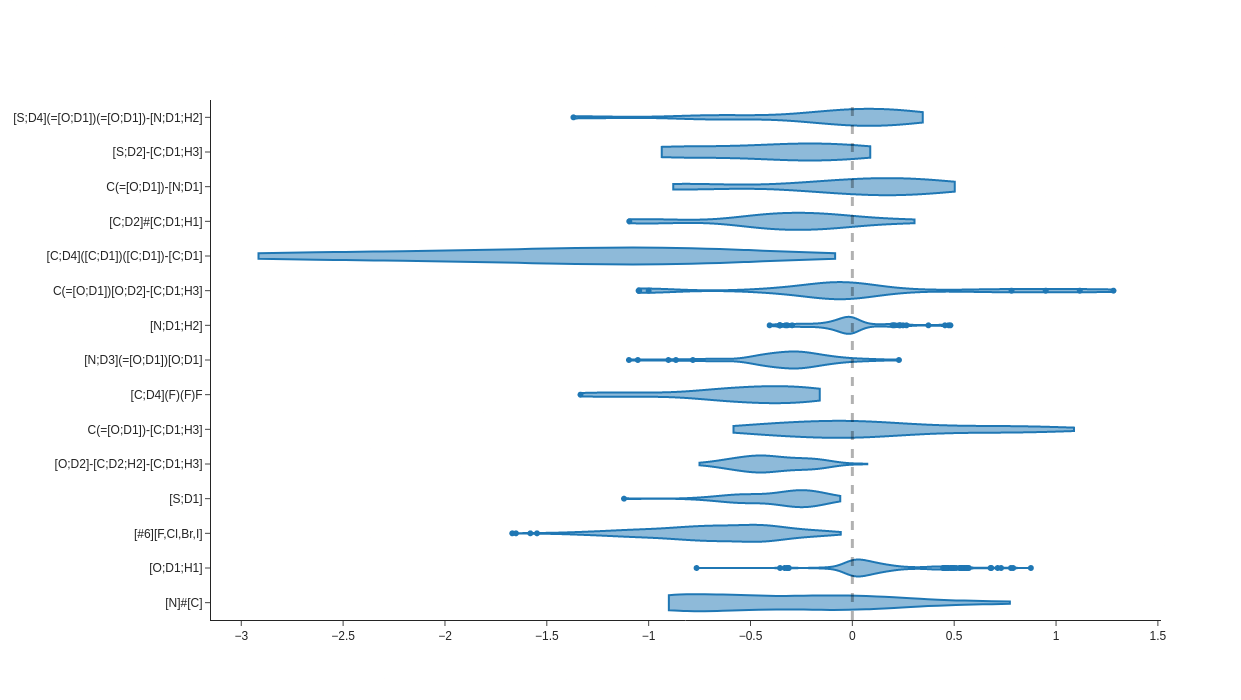

In [27]:
fig = go.Figure()

for functional_group, attributions in functional_group_attributions.items():
    print(f"{functional_group:<35}: {np.mean(attributions):.3f}")
    fig.add_trace(
        go.Violin(
            x=attributions, 
            name=functional_group, 
            spanmode="hard",
            line_color="#1f77b4",
            showlegend=False
        ),
        
    )
fig.add_vline(x=0, line_width=3, line_dash="dash")
fig.update_layout(autosize=False, width=700, height=700, template="simple_white")
fig.show()
# px.violin(functional_group_attributions["[N]#[C]"], width=600, height=500, template="simple_white")

### Menthol

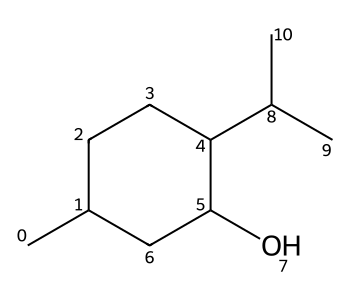

In [231]:
menthol_smiles = "CC1CCC(C(C1)O)C(C)C"
menthol_rdmol = Chem.MolFromSmiles(menthol_smiles)
menthol_rdmol
XAIChem.showMolecule(menthol_rdmol, show_atom_indices=True)

In [246]:
functionGroupNormalizedAttributionScores(menthol_smiles, functional_groups)

# XAIChem.showMolecule(menthol_rdmol, atoms_highlight_values={substructure: attribution_normalized}).show()

defaultdict(list, {'[O;D1]': [0.72]})

In [183]:
frags = list(BRICS.BRICSDecompose(menthol_rdmol))
mols = [Chem.MolFromSmiles(frag) for frag in frags]

In [13]:
bricks_substructures = [
    XAIChem.breakBRICKSBond(menthol_rdmol, bond[0])
    for bond in BRICS.FindBRICSBonds(menthol_rdmol)
]

In [16]:
for bricks_substructure in bricks_substructures:
    for substructure in bricks_substructure:


tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1])


In [196]:
graph = XAIChem.createDataObjectFromSmiles(menthol_smiles, -1)

with torch.no_grad():
    # Prediction of molecule without mask
    pred_mean, pred_sd = predict(graph)
    print(pred_mean, pred_sd)

    # Mask hydroxyl group
    pred_mean_masked_hydroxyl, pred_sd_masked_hydroxyl = predict(
        graph, mask.view(-1, 1)
    )
    print(pred_mean_masked_hydroxyl, pred_sd_masked_hydroxyl)

tensor(-3.8441) tensor(0.1910)
tensor(-4.2353) tensor(0.1500)


In [88]:
attribution = pred_mean - pred_mean_masked_hydroxyl
attribution_N = F.tanh(attribution)

In [89]:
attribution

tensor(0.9074)

In [90]:
attribution_N

tensor(0.7199)

### p-Menthane

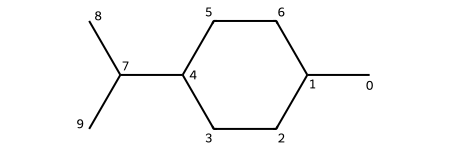

In [105]:
p_menthane_smiles = "CC1CCC(CC1)C(C)C"
p_menthane_rdmol = Chem.MolFromSmiles(p_menthane_smiles)
p_menthane_rdmol

In [47]:
graph = XAIChem.createDataObjectFromSmiles(p_menthane_smiles, -1)

with torch.no_grad():
    # Prediction of molecule without mask
    pred_mean, pred_sd = predict(graph)
    print(pred_mean, pred_sd)

tensor(-4.9916) tensor(0.1944)


In [48]:
np.exp(pred_mean)

tensor(0.0068)